# Homework 2 (Loans)

Description from Kaggle competation:  
The goal is to decide whether or not to approve a loan to a new client based on the predictors that are provided. If you predict a 1, that means that you are predicting that the customer will pay back the laon. The data columns are described in the MetaData.csv file. The response for training is the MIS_Status column, where PIF = paid in full = a successful loan.

You'll evaluate using the mean F1 score (see the Kaggle overview page for more information). Mean F1 scores closer to 1 are better scores. On the leaderboard I've included a benchmark which I created by randomly predicting 0 or 1 for the test data set (see random.guess on the leaderboard).

In [5]:
# import analysis packages
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import models
from keras.regularizers import l2
from keras.utils import to_categorical
import keras.backend as back
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

### Data Cleaning

In [6]:
# read data from .csvs
trainDF = pd.read_csv('./loan_train.csv')
testDF = pd.read_csv('./loan_test.csv')

# separate response/prediction columns
trainResp = np.where(trainDF['MIS_Status'] == 'P I F', 1, 0)
trainDF.drop('MIS_Status', axis = 1, inplace = True)
testIDs = testDF['CustomerId']
testDF.drop('CustomerId', axis = 1, inplace = True)

# combine data sets for preprocessing
trainDF['source'] = 'train'
testDF['source'] = 'test'
fullDF = pd.concat([trainDF, testDF], axis = 0)

# check data frame dimensions
display(trainDF.shape)
display(testDF.shape)
display(fullDF.shape)

# factor categorical predictors
fullDF['NAICS'] = fullDF['NAICS'].apply(lambda x: str(x))
fullDF['NewExist'] = fullDF['NewExist'].apply(lambda x: str(x))
fullDF['UrbanRural'] = fullDF['UrbanRural'].apply(lambda x: str(x))
fullDF['RevLineCr'] = np.where(fullDF['RevLineCr'] == 'Y', 'Y', 'N')
fullDF['LowDoc'] = np.where(fullDF['LowDoc'] == 'Y', 'Y', 'N')
fullDF['New'] = fullDF['New'].apply(lambda x: str(x))
fullDF['RealEstate'] = fullDF['RealEstate'].apply(lambda x: str(x))
fullDF['Recession'] = fullDF['Recession'].apply(lambda x: str(x))

# selected predictors
predictors = ['NAICS', 'Term', 'NoEmp', 'CreateJob', 'RetainedJob', 'UrbanRural', 'DisbursementGross', 'GrAppv', 'New', 'Portion', 'Recession']
src = fullDF['source']
fullDF = fullDF[predictors]

# check data types
display(fullDF.info())

# peek at data
display(fullDF.head())

(1102, 31)

(1000, 31)

(2102, 31)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NAICS              2102 non-null   object 
 1   Term               2102 non-null   int64  
 2   NoEmp              2102 non-null   int64  
 3   CreateJob          2102 non-null   int64  
 4   RetainedJob        2102 non-null   int64  
 5   UrbanRural         2102 non-null   object 
 6   DisbursementGross  2102 non-null   int64  
 7   GrAppv             2102 non-null   int64  
 8   New                2102 non-null   object 
 9   Portion            2102 non-null   float64
 10  Recession          2102 non-null   object 
dtypes: float64(1), int64(6), object(4)
memory usage: 197.1+ KB


None

,NAICS,Term,NoEmp,CreateJob,RetainedJob,UrbanRural,DisbursementGross,GrAppv,New,Portion,Recession
0,531210,84,2,0,0,2,11000,11000,0,0.50000,0
1,531312,300,7,0,7,1,866800,866800,0,0.75000,0
2,532230,84,3,0,3,1,77377,85000,0,0.50000,0
3,531312,300,10,0,0,1,800100,810000,0,0.75000,0
4,531210,300,2,0,2,1,1054200,1056200,0,0.72611,0


In [7]:
# scale numeric predictors and encode categorical predictors
findNumPredictors = make_column_selector(dtype_exclude = object)
findCatPredictors = make_column_selector(dtype_include = object)
transform = make_column_transformer((MinMaxScaler(), findNumPredictors),
                                    (OneHotEncoder(), findCatPredictors))

# get new column names
colNames = transform.fit(fullDF).get_feature_names_out()

# transform data
modelDF = pd.DataFrame.sparse.from_spmatrix(transform.fit_transform(fullDF), columns = colNames)

In [8]:
# split data into training, validation, and test sets
modelTrain = modelDF.loc[np.where(src == 'train')]
modelTest = modelDF.iloc[np.where(src == 'test')]
X_train, X_valid, y_train, y_valid = train_test_split(modelTrain, trainResp, test_size = 0.2, random_state = 4192023)

# check data frame dimensions
display(X_train.shape)
display(y_train.shape)
display(X_valid.shape)
display(y_valid.shape)
display(modelTest.shape) 

(881, 38)

(881,)

(221, 38)

(221,)

(1000, 38)

### Modeling

In [60]:
# set random seed
np.random.seed(4192023)

# tune KNN model
Kvalues = range(1, 50)
knnFit = KNeighborsClassifier()
knnTune = GridSearchCV(knnFit, param_grid = {'n_neighbors': Kvalues}, cv = 5, n_jobs = -1, verbose = 1)
knnTune.fit(X_train, y_train)
K = knnTune.best_params_['n_neighbors']

# fit KNN model
knnFit = KNeighborsClassifier(n_neighbors = K)
cvResults = cross_val_score(knnFit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
display(f"Neighbors considered: {K}")
display(f"Cross-validation F1 score: {(np.mean(cvResults)).round(3)}")

Fitting 5 folds for each of 49 candidates, totalling 245 fits


'Neighbors considered: 13'

'Cross-validation F1 score: 0.811'

In [62]:
# tune random forest classifier
Mvalues = range(1, len(X_train.columns))
rfFit = RandomForestClassifier(random_state = 4192023)
rfTune = GridSearchCV(rfFit, param_grid = {'max_features': Mvalues}, cv = 5, n_jobs = -1, verbose = 1)
rfTune.fit(X_train, y_train)
M = rfTune.best_params_['max_features']

# fit random forest model
rfFit = RandomForestClassifier(max_features = M, n_estimators = 1000, random_state = 4192023)
cvResults = cross_val_score(rfFit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
display(f"Features considered: {M}")
display(f"Cross-validation F1 score: {(np.mean(cvResults)).round(3)}")

Fitting 5 folds for each of 37 candidates, totalling 185 fits


'Features considered: 9'

'Cross-validation F1 score: 0.84'

In [74]:
# fit random forest model on full training set
rfFitted = rfFit.fit(X_train, y_train)

# identify most important predictors
pd.DataFrame({'Feature': rfFitted.feature_names_in_,
              'Importance': rfFitted.feature_importances_}).sort_values('Importance', ascending = False).head(10)

,Feature,Importance
0,minmaxscaler__Term,0.332751
4,minmaxscaler__DisbursementGross,0.139681
5,minmaxscaler__GrAppv,0.125430
1,minmaxscaler__NoEmp,0.068552
3,minmaxscaler__RetainedJob,0.065706
2,minmaxscaler__CreateJob,0.045104
6,minmaxscaler__Portion,0.040879
11,onehotencoder__NAICS_531210,0.016187
29,onehotencoder__NAICS_532490,0.014983
15,onehotencoder__NAICS_531390,0.011368


In [64]:
# tune gradient boosted classifier
Lvalues = [.001, .01, .1, 1, 10, 100]
Dvalues = range(1, 8)
gbFit = GradientBoostingClassifier(n_estimators = 1000, random_state = 4192023)
gbTune = GridSearchCV(gbFit, param_grid = {'learning_rate': Lvalues, 'max_depth': Dvalues}, cv = 5, n_jobs = -1, verbose = 1)
gbTune.fit(X_train, y_train)
L = gbTune.best_params_['learning_rate']
D = gbTune.best_params_['max_depth']

# fit gradient boosted model
gbFit = GradientBoostingClassifier(learning_rate = L, max_depth = D, n_estimators = 1000, random_state = 4192023)
cvResults = cross_val_score(gbFit, X_train, y_train, scoring = 'f1', cv = 10, n_jobs = -1, verbose = 0)

# cross-validation accuracy
display(f"Learning rate: {L}")
display(f"Maximum depth: {D}")
display(f"Cross-validation F1 score: {(np.mean(cvResults)).round(3)}")

Fitting 5 folds for each of 42 candidates, totalling 210 fits


'Learning rate: 0.1'

'Maximum depth: 1'

'Cross-validation F1 score: 0.856'

In [73]:
# fit gradient boosted model on full training set
gbFitted = gbFit.fit(X_train, y_train)

# identify most important predictors
pd.DataFrame({'Feature': gbFitted.feature_names_in_,
              'Importance': gbFitted.feature_importances_}).sort_values('Importance', ascending = False).head(10)

,Feature,Importance
0,minmaxscaler__Term,0.864660
5,minmaxscaler__GrAppv,0.019783
4,minmaxscaler__DisbursementGross,0.019203
3,minmaxscaler__RetainedJob,0.019010
1,minmaxscaler__NoEmp,0.015598
2,minmaxscaler__CreateJob,0.011298
6,minmaxscaler__Portion,0.011253
29,onehotencoder__NAICS_532490,0.009241
15,onehotencoder__NAICS_531390,0.007810
7,onehotencoder__NAICS_531110,0.004013


In [47]:
# model fitting and evaluation function
def EvaluateModel(model):
    # set random seed
    np.random.seed(462023)
    tf.random.set_seed(482023)

    # define F1 metric
    f1_score_metric = F1Score(num_classes = 1, threshold = 0.5)

    # compile model
    model.compile(optimizer = 'rmsprop',
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy', f1_score_metric])

    # model summary
    model.summary()

    # number of epochs
    EPOCHS = 50

    # early stopping criteria
    earlyStop = EarlyStopping(monitor = 'val_f1_score', mode = 'max', verbose = 1, patience = 3)

    # train model
    trained = model.fit(X_train, 
                        y_train, 
                        epochs = EPOCHS, 
                        batch_size = 100, 
                        validation_split = 0.2,
                        callbacks = earlyStop,
                        verbose = 1)

    # prepare model evaluation
    acc = trained.history['accuracy']
    val_acc = trained.history['val_accuracy']
    loss = trained.history['loss']
    val_loss = trained.history['val_loss']
    f1_score = trained.history['f1_score']
    val_f1_score = trained.history['val_f1_score']
    epochs = range(1, len(acc) + 1)

    print(f1_score)
    print(val_f1_score)

    # plot training accuracy
    plt.plot(epochs, acc, 'bo', label = 'Training acc')
    plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, f1_score, 'bo')
    plt.plot(epochs, val_f1_score, 'b')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()
    plt.show()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 512)               19968     
                                                                 
 dense_109 (Dense)           (None, 256)               131328    
                                                                 
 dense_110 (Dense)           (None, 128)               32896     
                                                                 
 dense_111 (Dense)           (None, 64)                8256      
                                                                 
 dense_112 (Dense)           (None, 32)                2080      
                                                                 
 dense_113 (Dense)           (None, 1)                 33        
                                                                 
Total params: 194,561
Trainable params: 194,561
Non-t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([0.7475468], dtype=float32), array([0.7625899], dtype=float32), array([0.7170732], dtype=float32), array([0.7800454], dtype=float32), array([0.76958], dtype=float32), array([0.7168832], dtype=float32), array([0.77511954], dtype=float32), array([0.7723404], dtype=float32), array([0.7675545], dtype=float32), array([0.78905356], dtype=float32)]
[array([0.6755556], dtype=float32), array([0.40579712], dtype=float32), array([0.6404494], dtype=float32), array([0.6886792], dtype=float32), array([0.1607143], dtype=float32), array([0.6560847], dtype=float32), array([0.73646206], dtype=float32), array([0.6560847], dtype=float32), array([0.67336684], dtype=float32), array([0.63387984], dtype=float32)]


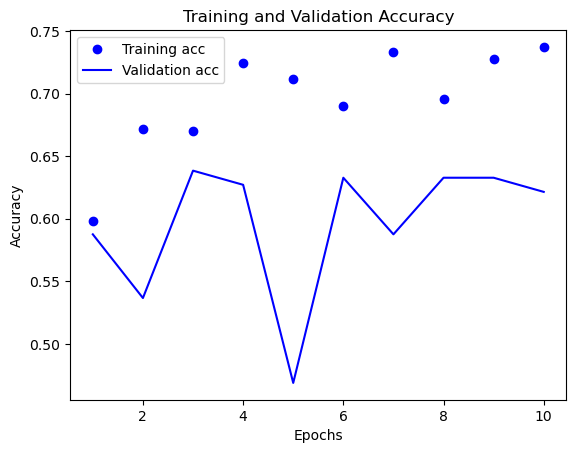

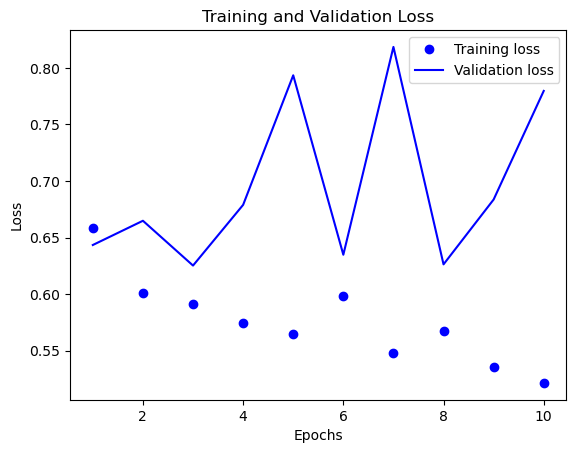

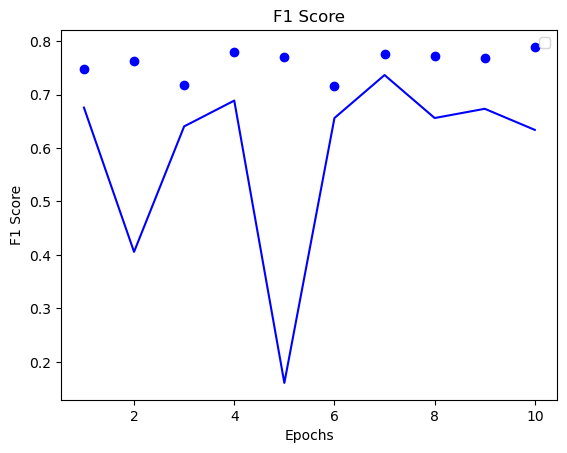

In [48]:
# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 512)               19968     
                                                                 
 dense_115 (Dense)           (None, 256)               131328    
                                                                 
 dense_116 (Dense)           (None, 128)               32896     
                                                                 
 dense_117 (Dense)           (None, 64)                8256      
                                                                 
 dense_118 (Dense)           (None, 32)                2080      
                                                                 
 dense_119 (Dense)           (None, 1)                 33        
                                                                 
Total params: 194,561
Trainable params: 194,561
Non-t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


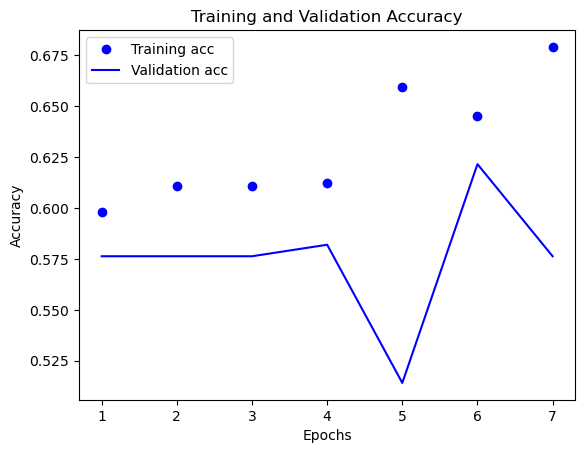

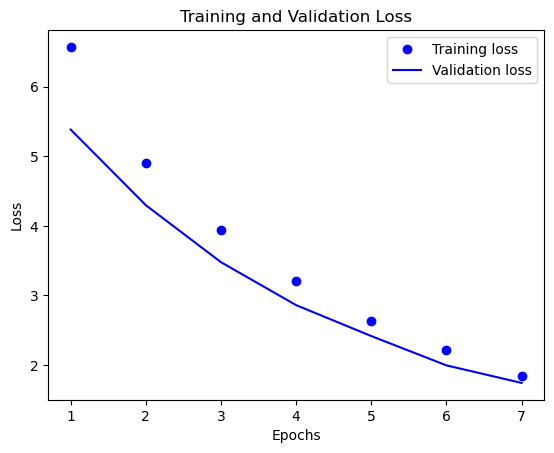

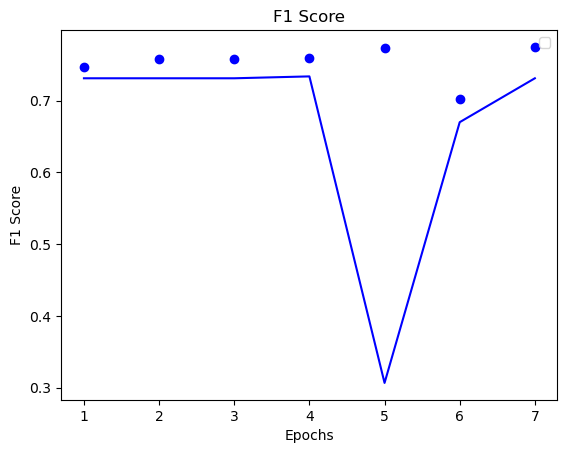

In [49]:
# penalty hyperparameter
PENALTY = 0.01

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 512)               19968     
                                                                 
 dense_121 (Dense)           (None, 256)               131328    
                                                                 
 dense_122 (Dense)           (None, 128)               32896     
                                                                 
 dense_123 (Dense)           (None, 64)                8256      
                                                                 
 dense_124 (Dense)           (None, 32)                2080      
                                                                 
 dense_125 (Dense)           (None, 1)                 33        
                                                                 
Total params: 194,561
Trainable params: 194,561
Non-t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([0.7475468], dtype=float32), array([0.7693857], dtype=float32), array([0.70036995], dtype=float32), array([0.77641827], dtype=float32), array([0.7622298], dtype=float32), array([0.7232948], dtype=float32), array([0.7593458], dtype=float32)]
[array([0.713615], dtype=float32), array([0.38167936], dtype=float32), array([0.64480877], dtype=float32), array([0.73819745], dtype=float32), array([0.32258064], dtype=float32), array([0.6734694], dtype=float32), array([0.73646206], dtype=float32)]


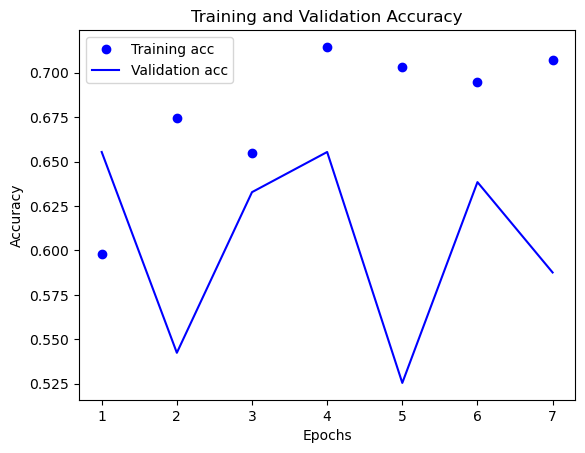

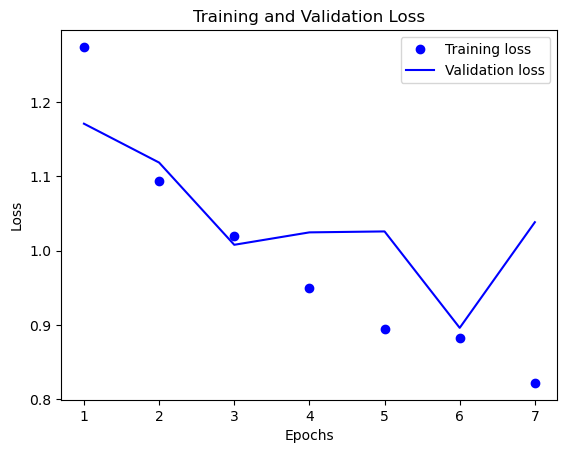

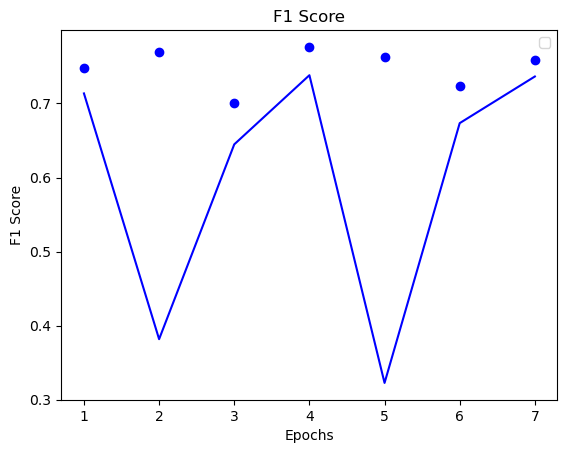

In [50]:
# penalty hyperparameter
PENALTY = 0.001

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', kernel_regularizer = l2(PENALTY), input_shape = (X_train.shape[1], )),
    Dense(256, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(128, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(64, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(32, activation = 'relu', kernel_regularizer = l2(PENALTY)),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_126 (Dense)           (None, 512)               19968     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_127 (Dense)           (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_128 (Dense)           (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_129 (Dense)           (None, 64)              

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([0.73377234], dtype=float32), array([0.7592426], dtype=float32), array([0.76117986], dtype=float32), array([0.7583333], dtype=float32), array([0.77802205], dtype=float32), array([0.7283951], dtype=float32), array([0.76089513], dtype=float32), array([0.7673099], dtype=float32), array([0.7762238], dtype=float32), array([0.78911567], dtype=float32)]
[array([0.7311828], dtype=float32), array([0.6883721], dtype=float32), array([0.71171165], dtype=float32), array([0.73593074], dtype=float32), array([0.52287585], dtype=float32), array([0.6494845], dtype=float32), array([0.7567568], dtype=float32), array([0.6633663], dtype=float32), array([0.71028036], dtype=float32), array([0.6666667], dtype=float32)]


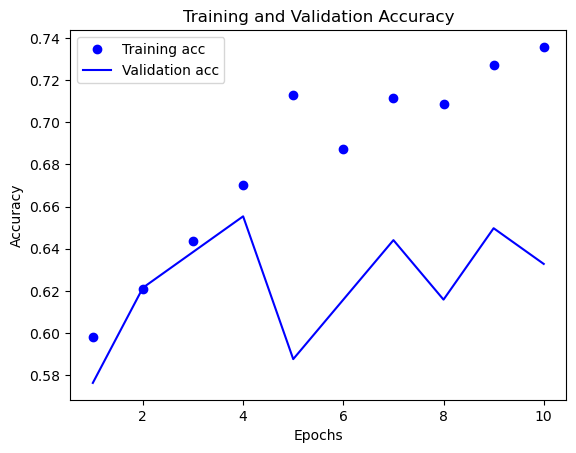

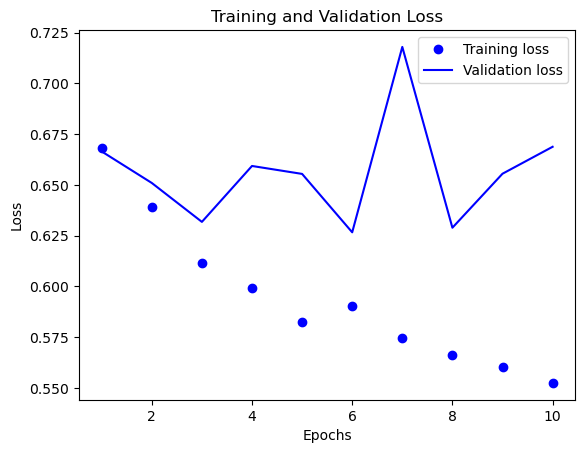

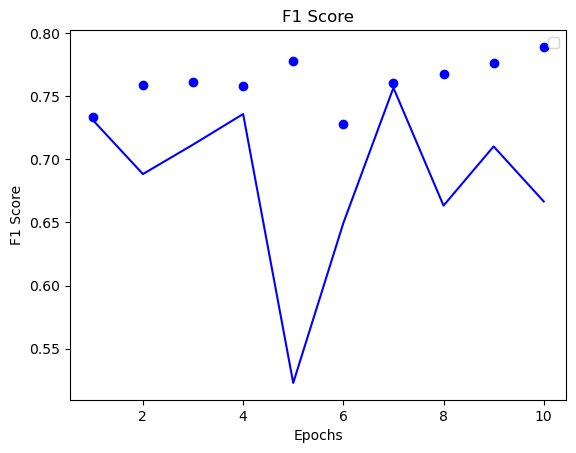

In [51]:
# penalty hyperparameter
RATE = 0.25

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dropout(RATE),
    Dense(32, activation = 'relu'),
    Dropout(RATE),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 512)               19968     
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_133 (Dense)           (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_134 (Dense)           (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_135 (Dense)           (None, 64)              

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([0.69353133], dtype=float32), array([0.7210885], dtype=float32), array([0.73408234], dtype=float32), array([0.7369402], dtype=float32)]
[array([0.7311828], dtype=float32), array([0.7311828], dtype=float32), array([0.7311828], dtype=float32), array([0.7311828], dtype=float32)]


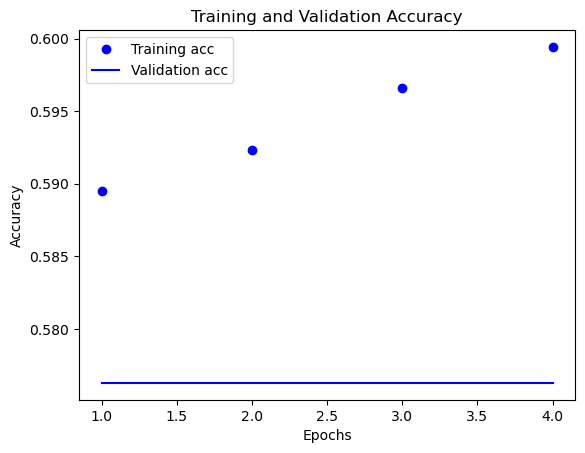

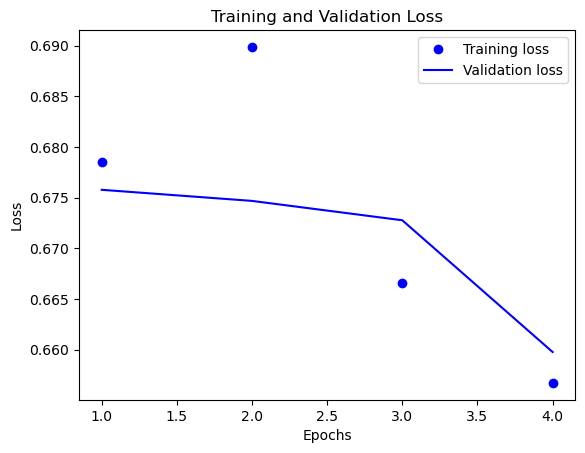

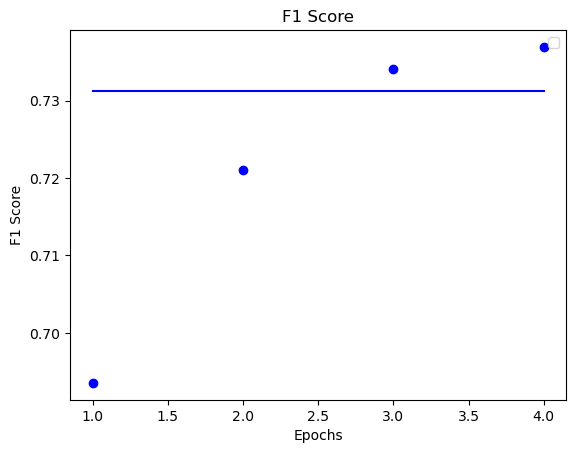

In [52]:
# penalty hyperparameter
RATE = 0.5

# define model architecture
model = models.Sequential([
    Dense(512, activation = 'relu', input_shape = (X_train.shape[1], )),
    Dropout(RATE),
    Dense(256, activation = 'relu'),
    Dropout(RATE),
    Dense(128, activation = 'relu'),
    Dropout(RATE),
    Dense(64, activation = 'relu'),
    Dropout(RATE),
    Dense(32, activation = 'relu'),
    Dropout(RATE),
    Dense(1, activation = 'sigmoid')
])

# evaluate model
EvaluateModel(model)